In [1]:
#! pip install dataretrieval
#! pip install bmipy
#! pip install --upgrade numpy
#! pip install hydroeval
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe_perturb_ens
import sys
sys.path.append("../observations")
import bmi_usgs
from usgs import USGS
import sys
sys.path.append("../da_methods")
import new_bmi_EnKF as bmi_EnKF
import bmi_cfe
import hydroeval as he

In [2]:
EXPLOTMAX = 2000

In [3]:
usgs_instance = bmi_usgs.BMI_USGS()
enkf_instance = bmi_EnKF.BMIEnKF('../da_methods/input_enkf_new.json')
cfe_purturb_instance = bmi_cfe_perturb_ens.BMI_CFE('./new_cfe_perturb.json')
cfe_instance = bmi_cfe.BMI_CFE('./new_cfe.json')

In [4]:
#initialization
cfe_purturb_instance.initialize()
cfe_instance.initialize()
enkf_instance.initialize()
usgs_instance.initialize(cfg_file='../observations/usgs_config.json', current_time_step=1)

In [5]:
######bare CFE

bare_cfe_all = []
bare_states_all = []
observations_all = []


with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)


df_forcing_first_800 = df_forcing.head(EXPLOTMAX)    
    

for t, (precip, pet) in enumerate(df_forcing_first_800[['preci', 'pet']].values):
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    pet = pet / 3600
    cfe_instance.set_value('water_potential_evaporation_flux', pet)
    cfe_instance.update()

    simulations = cfe_instance.get_value("land_surface_water__runoff_volume_flux")
    bare_cfe_all.append(simulations)

    state_variables = cfe_instance.get_value("SOIL_CONCEPTUAL_STORAGE")
    bare_states_all.append(state_variables)
    
    


cfe_instance.finalize()

In [6]:
######real loop


with open(cfe_purturb_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)


da_simulations_all = []
da_simulations_all_mean = []
state_variables_all = []
state_variables_all_mean = []
simulations_all = []
observations_all = []
updated_state_all = []
updated_simulations_all = []
gw_state_all = []
gw_state_all_mean = []
updated_gw_state_all = []



df_forcing_first_800 = df_forcing.head(EXPLOTMAX)    

for t, (precip, pet) in enumerate(df_forcing_first_800[['preci', 'pet']].values):

    cfe_purturb_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    pet = pet / 3600
    cfe_purturb_instance.set_value('water_potential_evaporation_flux', pet)
    cfe_purturb_instance.update()
    simulations = cfe_purturb_instance.get_value("land_surface_water__runoff_volume_flux")
    simulationsss = np.array(list(simulations.values()))
    da_simulations_all.append(simulationsss)
    mean_simulations = np.mean(simulationsss)
    da_simulations_all_mean.append(mean_simulations)
    
    state_variables = cfe_purturb_instance.get_value("SOIL_CONCEPTUAL_STORAGE")
    state_variablesssss = np.array(list(state_variables))
    state_variables_all.append(state_variables)
    state_variables_mean = np.mean(state_variablesssss)
    state_variables_all_mean.append(state_variables_mean)
    
    
#    gw_state = cfe_purturb_instance.get_value("DEEP_GW_TO_CHANNEL_FLUX")
 #   gw_statesssss = np.array(list(gw_state))
  #  gw_state_all.append(gw_state)
   # gw_state_mean = np.mean(gw_statesssss)
   # gw_state_all_mean.append(gw_state_mean)
    

    usgs_instance.update()
    Flow = usgs_instance.get_value("Flow")[t]
    Flow = Flow * 0.0283168
    observations_all.append(Flow)
    
    enkf_instance.initialize()
    enkf_instance.set_value('Observations', Flow) 
    enkf_instance.set_value('Simulations', simulations)
    enkf_instance.set_value('State Variables', state_variables)
    enkf_instance.update()
    updated_state_sm = enkf_instance.get_value("state_estimates")
    updated_state_all.append(updated_state_sm)
    updated_state_sm = updated_state_sm[0]
    
 #   enkf_instance.finalize()
  #  enkf_instance.initialize()
    
    
#    enkf_instance.set_value('Observations', Flow) 
 #   enkf_instance.set_value('Simulations', simulations)
  #  enkf_instance.set_value('State Variables', gw_state)
   # enkf_instance.update()
#    updated_state_gw = enkf_instance.get_value("state_estimates")
 #   updated_gw_state_all.append(updated_state_gw)
  #  updated_state_gw = updated_state_gw[0]
    
  #  enkf_instance.finalize()
    
    
#    list_of_states_gw = [updated_state_gw] * 1000
 #   cfe_purturb_instance.set_value('DEEP_GW_TO_CHANNEL_FLUX', list_of_states_gw)
    
    list_of_states_sm = [updated_state_sm] * 1000
    cfe_purturb_instance.set_value('SOIL_CONCEPTUAL_STORAGE', list_of_states_sm)
    
    
cfe_purturb_instance.finalize()
enkf_instance.finalize()
    
    


/home/jovyan/data/data_assimilation_with_bmi/example_run_da_CFE/bmi_cfe_perturb_ens.py:835: RuntimeWarning: divide by zero encountered in log
  perturbed_forcing = np.random.lognormal(0.5 * np.log(unperturbed_value / (error_factor_preci + 1)),       np.sqrt(np.log(error_factor_preci**2 + 1))) * unperturbed_value



GLOBAL MASS BALANCE
  initial volume:   1.2557
    volume input:   0.4142
   volume output:   0.0959
    final volume:   1.5291
        residual: 4.4813e-02

PARTITION MASS BALANCE
    surface runoff:   0.0031
      infiltration:   0.4111
 vol. et from rain:   0.0000
partition residual: -2.7756e-16

GIUH MASS BALANCE
  vol. into giuh:   0.0031
   vol. out giuh:   0.0031
 vol. end giuh q:   0.0000
   giuh residual: 0.0000e+00

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
     init soil vol:   0.0000
    vol. into soil:   0.4111
  vol.soil2latflow:   0.0314
   vol. soil to gw:   0.1154
 vol. et from soil:   0.0000
   final vol. soil:   1.4715
  vol. soil resid.: -1.2073e+00

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0314
  vol. from nash:   0.0314
 final vol. nash:   0.0001
nash casc resid.: -3.3692e-17

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0000
       vol to gw:   0.1154
     vol from gw:   0.0614
final gw.storage:   0.0576
    

In [7]:
###############Calculate quantiles



da_quantile_5 = np.percentile(da_simulations_all, 5, axis=1)
da_quantile_95 = np.percentile(da_simulations_all, 95, axis=1)


da_quantile_15 = np.percentile(da_simulations_all, 15, axis=1)
da_quantile_85 = np.percentile(da_simulations_all, 85, axis=1)

[]

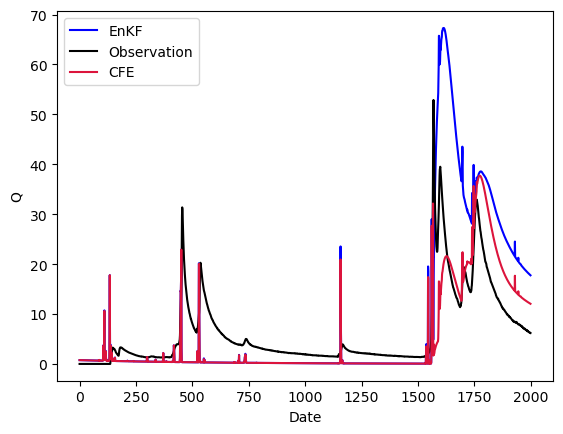

In [8]:
plt.close()
plt.plot(da_simulations_all_mean[:EXPLOTMAX], color='blue', label='EnKF')
plt.plot(observations_all[:EXPLOTMAX], color='black', label='Observation')
plt.plot(bare_cfe_all[:EXPLOTMAX], color='crimson', label='CFE')


plt.xlabel('Date')
plt.ylabel('Q')
plt.legend()
plt.plot()
#import matplotlib
#matplotlib.use('Agg')
#Save the plot as an image file
#plt.savefig('mean_Q.tif', backend='Agg')

[]

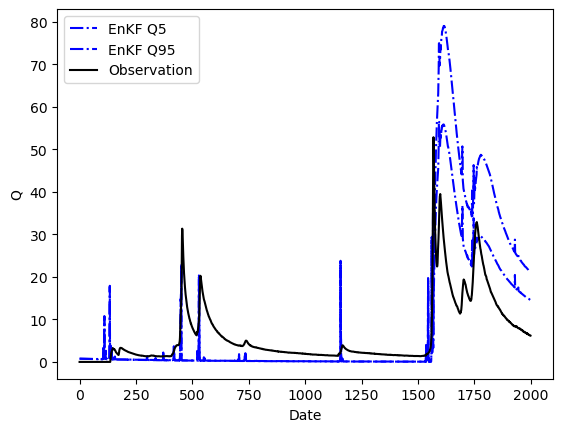

In [9]:
plt.close()
plt.plot(da_quantile_5[:EXPLOTMAX], color='blue', label='EnKF Q5', linestyle='-.')
plt.plot(da_quantile_95[:EXPLOTMAX], color='blue', label='EnKF Q95', linestyle='-.')
#plt.plot(open_quantile_85, color='red', label='Open Loop Q85', linestyle='--')
#plt.plot(open_quantile_15[60:100], color='red', label='Open Loop Q15', linestyle='--')
#plt.plot(da_quantile_15[60:100], color='blue', label='DA Loop Q15', linestyle='-.')
#plt.plot(da_quantile_85[60:100], color='blue', label='DA Loop Q85', linestyle='-.')
plt.plot(observations_all[:EXPLOTMAX], color='black', label='Observation')




plt.xlabel('Date')
plt.ylabel('Q')
plt.legend()
plt.plot()
#import matplotlib
#matplotlib.use('Agg')
# Save the plot as an image file
#plt.savefig('synthetic_loop.tif', backend='Agg')

In [12]:
from hydrostats.metrics import kge_2009 as kge

kge_score_DA = kge(da_simulations_all_mean[:EXPLOTMAX], observations_all[:EXPLOTMAX])
kge_score_OL = kge(bare_cfe_all[:EXPLOTMAX], observations_all[:EXPLOTMAX])
print("Kling-Gupta Efficiency for DA:", kge_score_DA)
print("Kling-Gupta Efficiency for CFE:", kge_score_OL)


Kling-Gupta Efficiency for DA: -0.08128721665011795
Kling-Gupta Efficiency for CFE: 0.597346459719587


In [13]:
from hydrostats.metrics import nse

nse_score_DA = nse(da_simulations_all_mean[:EXPLOTMAX], observations_all[:EXPLOTMAX])
nse_score_OL = nse(bare_cfe_all[:EXPLOTMAX], observations_all[:EXPLOTMAX])
print("NSE for DA:", nse_score_DA)
print("NSE for CFE:", nse_score_OL)

NSE for DA: -0.9180096744172626
NSE for CFE: 0.2986559738391328


In [14]:
from hydrostats.metrics import rmse

rmse_score_DA = rmse(da_simulations_all_mean[:EXPLOTMAX], observations_all[:EXPLOTMAX])
rmse_score_OL = rmse(bare_cfe_all[:EXPLOTMAX], observations_all[:EXPLOTMAX])
print("RMSE for DA:", rmse_score_DA)
print("RMSE for CFE:", rmse_score_OL)

RMSE for DA: 10.880338276323407
RMSE for CFE: 6.579343369882805


In [15]:
#np.save("real_da_all_mean_v2", da_simulations_all_mean)

In [16]:
#np.save("real_da_simulations_all_v2", da_simulations_all)

In [17]:
#np.save("real_observation_v2", observations_all)

In [18]:
#np.save("real_bare_cfe_all_v2", bare_cfe_all)